# Dataset Setup

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS

Transferring data from a spreadsheet to a Pandas DataFrame; allows for easier manipulation of data from function to function and allows for better visualization

In [2]:
stock_data = pd.read_csv("Datasets/final_set.csv")

data = []

# and i[5] == "Quebec"

for i in stock_data.values:
    if i[8] == "Residential" and i[9] == "Flat":
        data.append(i)
df = pd.DataFrame(data)

df.columns = [
    "Municipality",
    "Latitude",
    "Longitude",
    "CGNDB ID",
    "Generic Term",
    "Province - Territory",
    "Nearest NSRDB latitude",
    "Nearest NSRDB longitude",
    "Array Type",
    "Market Pricing",
    "Tariff Applied",
    "First Yr Annual (MWh)",
    "First Yr Winter (MWh)",
    "First Yr Spring (MWh)",
    "First Yr Summer (MWh)",
    "First Yr Fall (MWh)",
    "Installation Cost Scenario",
    "Breakeven Price ($/MWh)",
    "Reference Price ($/MWh)",
    "Breakeven Price (¢/kWh)",
    "Reference Price (¢/kWh)",
    "Total Capacity (MW)",
    "Annual",
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

In [3]:
print(df)

        Municipality  Latitude  Longitude CGNDB ID             Generic Term  \
0     100 Mile House     51.64    -121.29    JCBMZ    District Municipality   
1     108 Mile Ranch     51.75    -121.35    JBHFG                Community   
2      70 Mile House     51.30    -121.40    JCCIT                Community   
3              Abbey     50.73    -108.75    HABJF                  Village   
4         Abbotsford     49.05    -122.32    JABNO                     City   
...              ...       ...        ...      ...                      ...   
4082       Zealandia     51.61    -107.74    HAVTP                     Town   
4083        Zeballos     49.98    -126.84    JBTDH                  Village   
4084      Zenon Park     53.06    -103.75    HAVTX                  Village   
4085          Zephyr     44.20     -79.26    FDGAU  Compact Rural Community   
4086          Zurich     43.42     -81.62    FDGCX                Community   

     Province - Territory  Nearest NSRDB latitude  

# Model

This model splits the dataset such that one-third is used to fit the model and the rest is used for evaluation. The `GridSearchCV()` function automatically tests and validates a preset range of model parameters; in this instance, when paired with a `KNeighborsRegressor()` model, `GridSearchCV()` performs a search of the best K value for the model between 1 and 20; it additionally finds the best K Fold value for cross validation. This is performed on an initial `train` set and the best parameters, when found, are applied to evaluate the `eval` set.

In [4]:
df_feats = df[["Latitude", "Longitude", "Total Capacity (MW)", "Annual"]]
df_labels = df[["First Yr Annual (MWh)"]]

In [5]:
rstate=4
tts=0.6

In [6]:
feats_train, feats_eval, labels_train, labels_eval = train_test_split(df_feats, df_labels, train_size=tts, random_state=rstate)

In [7]:
model = KNeighborsRegressor(weights="distance")
knn_grid = {"n_neighbors": np.arange(1, 21)}
model_knn = GridSearchCV(model, knn_grid, cv=9)
model_knn.fit(feats_train, labels_train)

print("Best K Value: ", model_knn.best_params_)
print("R^2 - Fit: ", model_knn.best_score_, "\n")



Best K Value:  {'n_neighbors': 6}
R^2 - Fit:  0.914068877956755 



In [8]:
print(pd.DataFrame(model_knn.cv_results_))

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.002780  4.159505e-04         0.001780    4.160425e-04   
1        0.002558  4.972471e-04         0.001779    4.160848e-04   
2        0.002558  4.974011e-04         0.002002    1.498555e-07   
3        0.002558  4.972827e-04         0.002002    4.718200e-04   
4        0.003114  7.376852e-04         0.002336    4.718387e-04   
5        0.003114  7.375853e-04         0.002336    6.672541e-04   
6        0.002836  4.718855e-04         0.002002    1.589457e-07   
7        0.003003  4.718766e-04         0.002336    4.719328e-04   
8        0.002780  4.159086e-04         0.002113    3.146404e-04   
9        0.002669  4.718762e-04         0.002335    4.718574e-04   
10       0.002669  4.719136e-04         0.002002    3.371748e-07   
11       0.002780  4.160495e-04         0.001891    3.144998e-04   
12       0.002669  4.718950e-04         0.002002    1.946680e-07   
13       0.002558  4.971820e-04         0.002002

In [9]:
output = model_knn.predict(feats_eval)
print("R^2 - Evaluation: ", r2_score(labels_eval, output))


R^2 - Evaluation:  0.9170542627118071


In [10]:
labels_eval = pd.DataFrame.to_numpy(labels_eval)

In [11]:
errors = []

#   mean_absolute_error()
#   mean_absolute_percentage_error()

for i in range(len(output)):
    errors.append(mean_absolute_percentage_error(labels_eval[i], output[i])*100)

errors = pd.DataFrame(errors)

In [12]:
print(mean_absolute_error(labels_eval, output))
print(mean_absolute_percentage_error(labels_eval, output))

0.08562550829769518
0.013590432781186377


In [13]:
print(labels_eval[0])

[6.95]


# Model Performance Mapping

In [14]:
mapdata = feats_eval
powers = labels_eval

In [15]:
mapdata.insert(3, "Error", errors)
mapdata.insert(4, "Power Produced", powers)
mapdata.insert(4, "Prediction", output)


Predictions made for each datapoint by the model can be mapped out on a geographical plot to visualize any location-influenced errors. By color coding each prediction point according to how far away from the actual value it is, patterns can be observed and conclusions drawn on the current model's behaviour.

Text(0.5, 1.0, 'Error (percentage)')

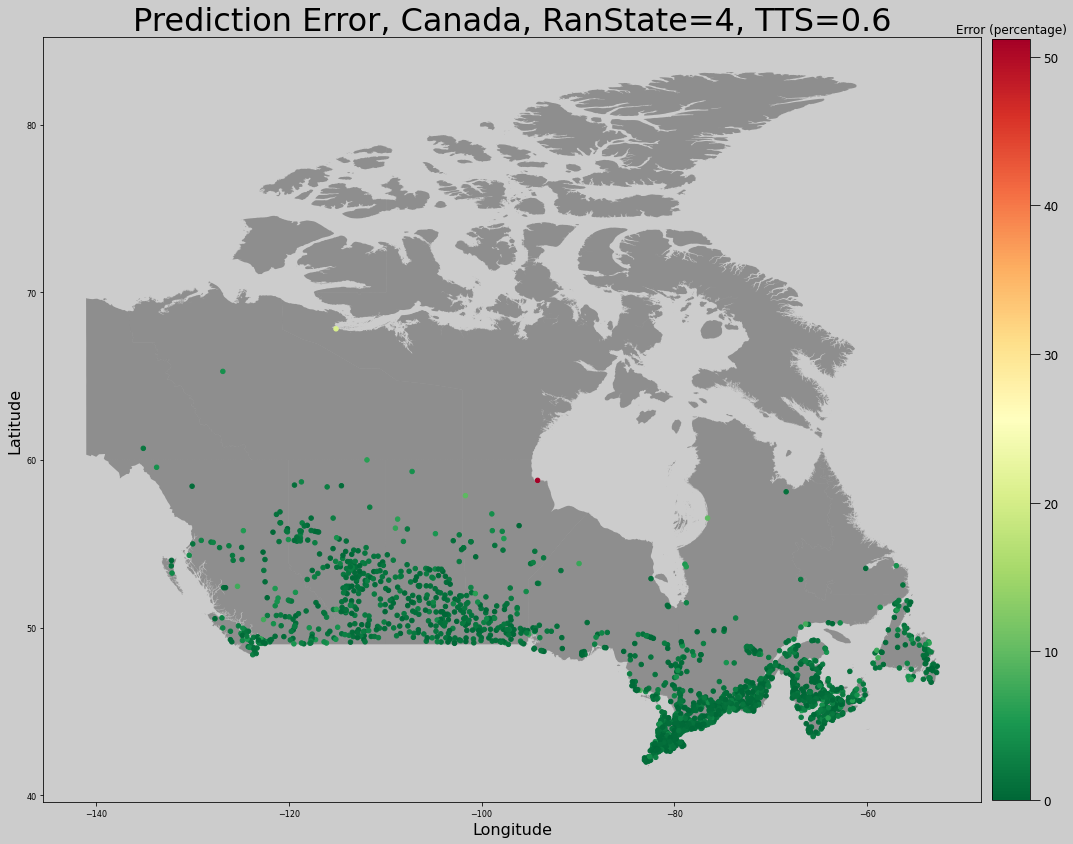

In [16]:
map = gpd.read_file("Shapefile/canada.shp")
fig, ax = plt.subplots(figsize=(20, 20))
crs = CRS("EPSG:4326")

geometry = [Point(xy) for xy in (zip(mapdata["Longitude"], mapdata["Latitude"]))]
geoframe = gpd.GeoDataFrame(mapdata, crs=crs, geometry=geometry)

geography = map.plot(ax=ax, alpha=0.3, color="black")
plt.title("Prediction Error, Canada, RanState=" + str(rstate) + ", TTS=" + str(tts), fontsize=32)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
fig.patch.set_facecolor((0.80, 0.80, 0.80))
ax.set_facecolor((0.80, 0.80, 0.80))

#   cmap="RdYlGn_r"
#   color="black"

plotpoints = geoframe.plot(ax=ax, markersize=20, column="Error", legend_kwds={"shrink": 0.7, "pad": 0.01}, legend=True, cmap="RdYlGn_r")

pointfig = plotpoints.figure
pointax = pointfig.axes[1]
pointax.tick_params(labelsize=12, length=10)
pointax.set_title("Error (percentage)")



# Dataset Visualization

Error vs. latitude for evaluated points

Text(0, 0.5, 'Prediction Error')

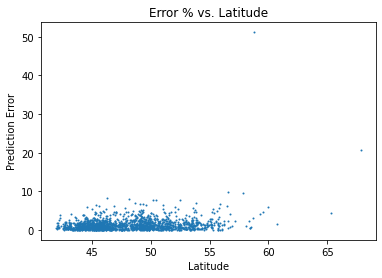

In [17]:
graph = pd.DataFrame(feats_eval["Latitude"])
graph.insert(1, "Error", errors)
graph = graph.sort_values(by=["Latitude"])

plt.scatter(graph["Latitude"], graph["Error"], s=1)
plt.title("Error % vs. Latitude")
plt.xlabel("Latitude")
plt.ylabel("Prediction Error")

Array distribution by latitude for evaluated points

Text(0, 0.5, 'Count')

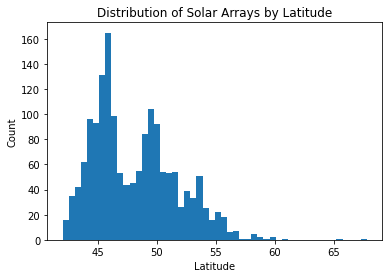

In [18]:
plt.hist(graph["Latitude"], bins=50)
plt.title("Distribution of Solar Arrays by Latitude")
plt.xlabel("Latitude")
plt.ylabel("Count")

Power vs. latitude for all installations in Canada

Text(0.5, 1.0, 'Power vs. Latitude')

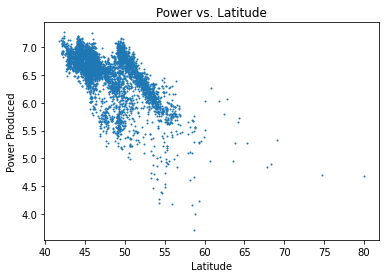

In [19]:
testgraph = df.sort_values(by=["Latitude"])

plt.scatter(testgraph["Latitude"], testgraph["First Yr Annual (MWh)"], s=1)
plt.xlabel("Latitude")
plt.ylabel("Power Produced")
plt.title("Power vs. Latitude")